In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [8]:
#to load images into tensorflow
df=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names=df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(df)

68

In [13]:
df

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [17]:
for image, label in df.take(1):
    print(image.shape) #3 is rgb channels,  32 is due to batch size
    print(label.numpy())

(32, 256, 256, 3)
[0 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 1 1 1]


In [19]:
for image, label in df.take(1):
    print(label)

tf.Tensor([1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 2 2 1 1 0 0 0], shape=(32,), dtype=int32)


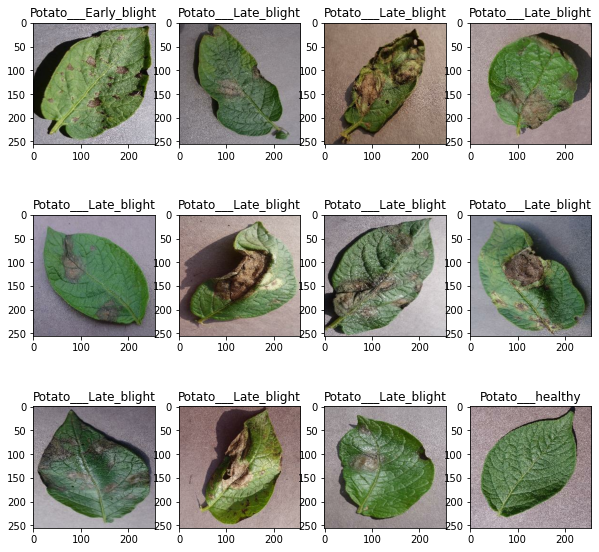

In [12]:
plt.figure(figsize=(10,10))
for image, label in df.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])

In [7]:
data=int(0.8*len(df))
train=df.take(data) #train
len(train)

54

In [8]:
te=df.skip(data) #validation and test

In [9]:
len(te)
validation=te.take(7)
test=te.skip(7)
len(validation), len(test)

(7, 7)

In [10]:
def get_partition_function(ds, train_size=0.8, val_size=0.1,test_size=0.1, shuffle=True,shuffle_size=10000):
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    ds_size=len(ds)
    train=ds.take(int(train_size*ds_size))
    val=ds.skip(int(train_size*ds_size)).take(int(ds_size*val_size))
    test=ds.skip(int(train_size*ds_size)).skip(int(ds_size*val_size))
    
    return train, test, val

In [11]:
train,test,val=get_partition_function(df)

In [12]:
len(train),len(test),len(val)

(54, 8, 6)

In [13]:
train_ds=train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# data augmentation (turning, contract,zoom) 

In [15]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

# CNN 

In [16]:
train_ds=train_ds.map(
    lambda x,y: (data_augmentation(x,training=True),y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation="softmax"),

])
model.build(input_shape=(32,256,256,3))

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [20]:
history = model.fit(
    train_ds,
    batch_size=(256,256),
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 95s 2s/step - loss: 0.9070 - accuracy: 0.4774 - val_loss: 0.8824 - val_accuracy: 0.4479
Epoch 2/10
54/54 [==============================] - 83s 2s/step - loss: 0.7326 - accuracy: 0.6424 - val_loss: 0.4816 - val_accuracy: 0.8229
Epoch 3/10
54/54 [==============================] - 84s 2s/step - loss: 0.4371 - accuracy: 0.8061 - val_loss: 0.3169 - val_accuracy: 0.8854
Epoch 4/10
54/54 [==============================] - 86s 2s/step - loss: 0.3293 - accuracy: 0.8582 - val_loss: 0.2431 - val_accuracy: 0.9219
Epoch 5/10
54/54 [==============================] - 87s 2s/step - loss: 0.2675 - accuracy: 0.8906 - val_loss: 0.2299 - val_accuracy: 0.9271
Epoch 6/10
54/54 [==============================] - 88s 2s/step - loss: 0.2670 - accuracy: 0.8953 - val_loss: 1.2219 - val_accuracy: 0.6927
Epoch 7/10
54/54 [==============================] - 87s 2s/step - loss: 0.2654 - accuracy: 0.9016 - val_loss: 0.4337 - val_accuracy: 0.8333
Epoch 8/10
54/54 [==

In [23]:
scores=model.evaluate(test)

8/8 [==============================] - 4s 319ms/step - loss: 0.1584 - accuracy: 0.9526


In [24]:
scores

[0.15835948288440704, 0.9525862336158752]

# plotting accuracy and loss curves

In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [28]:
type(history.history['loss']),len(history.history['loss'])

(list, 10)

In [29]:
history.history['loss']

[0.9069855213165283,
 0.7326195240020752,
 0.4371025860309601,
 0.32932621240615845,
 0.2675391733646393,
 0.267041951417923,
 0.2654155492782593,
 0.21042044460773468,
 0.180090993642807,
 0.10850566625595093]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

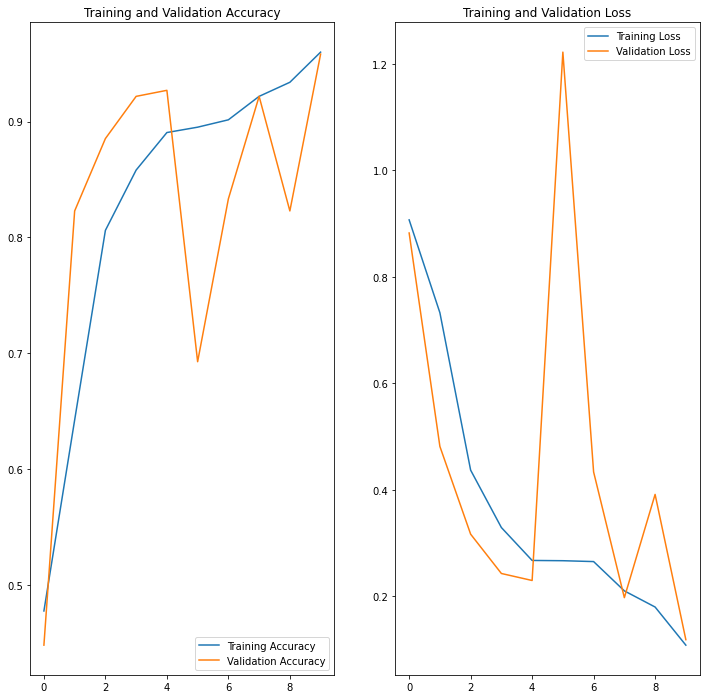

In [35]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Running prediction on sample image

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


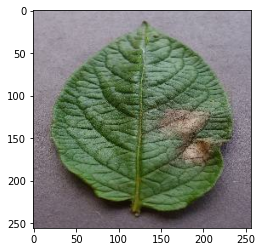

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Program for interface

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# saving model

In [49]:
import os
model_version=max([int(i) for i in os.listdir("model")+[0]])+1
model.save(f"model/{model_version}")

INFO:tensorflow:Assets written to: model/2\assets
